## **Product Classification**

This notebook contains all the code to build the models for the product classification

Install libraries

In [ ]:
# Installing
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


Import libraries

In [ ]:
# Importing
import torch
import pandas as pd
from google.colab import drive, files
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv,SAGEConv
from torch_geometric.data import Data
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter
from matplotlib import pyplot as plt
import ast
import copy
import matplotlib.pyplot as plt

# Getting access to google drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the product descriptions and prices

In [ ]:
# Getting the available device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting the path of the drive
drive_path = "/content/drive/MyDrive/Data Science Challenge/deliverable/"

# Reading
product_descriptions = pd.read_excel(drive_path + "data/product_descriptions.xlsx")

# Dropping
product_descriptions.drop(columns=["description"], inplace=True)

# Reading
product_prices = pd.read_excel(drive_path + "data/product_prices.xlsx")

# Merging
products = pd.merge(product_descriptions, product_prices, how="left", on="product_id")

Process and normalize the product prices

In [ ]:
# Filling any missing values with the median price value
products["price"] = products["price"].fillna(products["price"].median())

# Normalizing the price values
normalizer = StandardScaler()
normalized_product_prices = normalizer.fit_transform(
    products["price"].values.reshape(-1, 1)
)

# Converting to torch tensor
product_prices_tensor = torch.tensor(normalized_product_prices, dtype=torch.float)

Load the text embeddings and get the initial product features

In [ ]:
# Loading
text_embeddings = torch.load(drive_path + "data/text_embeddings.pt")

# Concatenating
product_features = torch.cat([text_embeddings, product_prices_tensor], dim=1)

print(f"The shape of the initial product features:\n {product_features.shape}")

The shape of the initial product features:
 torch.Size([276453, 769])


Load and process the undirected product graph

In [ ]:
# Opening the file
undirected_graph_file = open(drive_path + "data/undirected_products_graph.txt", "r")

# Reading the lines of the file
lines = undirected_graph_file.readlines()

# Setting a list for the graph edges
edge_list = []

# Iterating over the lines
for line in lines:

    # Appending
    edge_list.append(ast.literal_eval(line.strip()))

# Closing the file
undirected_graph_file.close()

# Converting to tensor
edge_tensor = torch.tensor(edge_list, dtype=torch.long).T

print(f"Print some edges:\n {edge_list[:5]}")

Print some edges:
 [[251528, 237411], [237411, 251528], [100805, 74791], [74791, 100805], [38634, 97747]]


Load and process the training and test datasets

In [ ]:
# Reading the datasets
training_dataset_df = pd.read_excel(drive_path + "data/training_dataset.xlsx")
test_dataset_df = pd.read_excel(drive_path + "data/test_dataset.xlsx")

# Dropping
training_dataset_df.drop(columns=["description"], inplace=True)
test_dataset_df.drop(columns=["description"], inplace=True)

# Adding labels and type
test_dataset_df.insert(1, "label", -1)
test_dataset_df.insert(2, "type", "test")
training_dataset_df.insert(2, "type", "train")

# Concatenating
labels_types_df = pd.concat([training_dataset_df, test_dataset_df], ignore_index=True)

# Merging
products = pd.merge(products, labels_types_df, how="left", on="product_id")

### **GraphSAGE**

Define a class that represents the GraphSAGE neural network for product classification

In [ ]:
class GraphSAGEClassifier(nn.Module):

    def __init__(self, layer_dims, dropout):
        """
        This is the constructor of the GraphSAGE classifier.

        :param layer_dims: List of dimensions for each layer
        :param dropout: Dropout rate
        """

        # Calling the constructor of the superclass
        super().__init__()

        # Setting the layers and the dropout
        self.num_layers = len(layer_dims) - 1
        self.dropout = dropout

        # Setting lists for the SAGE layers and batch normalization
        self.sage = nn.ModuleList()
        self.bns = nn.ModuleList()

        # Iterating over the layers
        for i in range(self.num_layers):

            # Appending a SAGE layer
            self.sage.append(SAGEConv(layer_dims[i], layer_dims[i + 1]))

            # Checking for the final layer (output layer - 16 logits)
            if i < self.num_layers - 1:

                # Adding batch normalization
                self.bns.append(nn.BatchNorm1d(layer_dims[i + 1]))

    def forward(self, x, edge_index):
        """
        The forward function of the GraphSAGE classifier.

        :param x: Input features
        :param edge_index: Graph edges
        :return: Output logits
        """

        # Iterating over the layers
        for i in range(self.num_layers):

            # Setting the residual
            residual = x

            # Passing from the SAGE layer
            x = self.sage[i](x, edge_index)

            # Checking for the final layer (output layer - 16 logits)
            if i < self.num_layers - 1:

                # Apply batch normalization
                x = self.bns[i](x)

                # Apply the ReLU activation function
                x = F.relu(x)

                # Apply dropout
                x = F.dropout(x, p=self.dropout, training=self.training)

                # Checking the shapes
                if residual.shape == x.shape:

                    # Adding the residual
                    x += residual

        return x

Define a function for training a graph neural network

In [ ]:
def train_graph_neural_network(
    model, data, epochs, patience, learning_rate, weight_decay
):
    """
    This function is used to train a graph neural network.

    :param model: The model to use
    :param data: The data to use
    :param epochs: The number of epochs
    :param patience: The patience
    :param learning_rate: The learning rate
    :param weight_decay: The weight decay
    :return: The best trained model
    """

    # Setting the Adam optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    # Setting the cross-entropy criterion/loss
    criterion = nn.CrossEntropyLoss()

    # Inititaling some variables
    best_validation_loss = float("inf")
    best_model_state = None
    best_epoch = 0
    patience_counter = 0

    # Setting two lists for the training and validation losses
    training_losses = []
    validation_losses = []

    # Iterating over the epochs
    for epoch in range(1, epochs + 1):

        # Setting the model in training mode
        model.train()

        # Initializing the optimizer
        optimizer.zero_grad()

        # Passing the product features and graph edges
        model_outputs = model(data.x, data.edge_index)

        # Computing the criterion loss (function loss)
        training_loss = criterion(
            model_outputs[data.training_mask], data.labels[data.training_mask]
        )

        # Applying backpropagation - Computing loss gradients
        training_loss.backward()

        # Updating the weights
        optimizer.step()

        # Setting the model in evaluation mode
        model.eval()

        # Without using the gradient computations
        with torch.no_grad():

            # Predicting
            outputs = model(data.x, data.edge_index)

            # Computing the validation loss
            validation_loss = criterion(
                outputs[data.validation_mask], data.labels[data.validation_mask]
            )

        # Appending
        training_losses.append(training_loss.item())
        validation_losses.append(validation_loss.item())

        print(
            f"Epoch {epoch:03d} | Train Loss: {training_loss.item():.4f} | "
            f"Validation Loss: {validation_loss.item():.4f}"
        )

        # Checking for the minimum validation loss
        if validation_loss < best_validation_loss:

            # Updating
            best_validation_loss = validation_loss
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            patience_counter = 0

        else:

            # Updating the early-stopping counter
            patience_counter += 1

            # Checking for early stopping
            if patience_counter >= patience:

                print(f" Early stopping at epoch {epoch}")

                break

    # Loading the best model
    model.load_state_dict(best_model_state)

    return model, training_losses, validation_losses, best_epoch

Define a function for showing the training and validation losses across all epochs of a training process

In [ ]:
def show_losses(training_losses, validation_losses, best_epoch, limit, step, ax=None):
    """
    This function is used to show the training and validation losses across all
    epochs of a training process.

    :param training_losses: The training losses
    :param validation_losses: The validation losses
    :param best_epoch: The best epoch
    :param limit: The limit for the x-axis
    :param step: The step for the x-axis
    :param ax: The axis to plot on
    :return: None
    """

    # Checking
    if ax is None:

        # Setting the figure and ax
        fig, ax = plt.subplots(figsize=(12, 6))

    # Plotting the curves
    ax.plot(training_losses, label="Training Loss", linewidth=2, color="royalblue")
    ax.plot(validation_losses, label="Validation Loss", linewidth=2, color="orangered")
    ax.axvline(
        best_epoch,
        linestyle="--",
        color="gray",
        linewidth=1.5,
        label=f"Best Epoch ({best_epoch})",
    )

    # Setting plot parameters
    ax.set_xlim(0, limit)
    ax.set_xticks(np.arange(0, limit, step))
    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Loss", fontsize=14)
    ax.set_title("Training vs Validation Loss", fontsize=16, weight="bold")
    ax.legend(fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5)

    # Checking
    if ax is None:

        # Showing
        plt.tight_layout()
        plt.show()

Set the labels, masks and the stratified 5-folds

In [ ]:
# Getting all labels (true and fake)
labels_array = products["label"].fillna(-1).astype(int).values
labels_tensor = torch.tensor(labels_array, dtype=torch.long)

# Getting the training and test masks
training_mask = products["type"] == "train"
test_mask = products["type"] == "test"

# Get training indices and labels
global_training_indices = np.where(training_mask)[0]
training_labels = labels_array[training_mask]

# Converting to tensors
training_mask_tensor = torch.tensor(training_mask, dtype=torch.bool)
test_mask_tensor = torch.tensor(test_mask, dtype=torch.bool)

# Moving to the available device
product_features = product_features.to(device)
edge_tensor = edge_tensor.to(device)
labels = labels_tensor.to(device)
test_mask = test_mask_tensor.to(device)

# Setting a list for keeping the probabilities of all the folds
all_folds_probs = []

# Setting up a stratified 5-Fold
str_5_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Train five GraphSAGE models for each fold and keep their predictions on the test data

In [ ]:
# Setting four lists for the training and validation losses, the best epochs and classification reports across the folds
folds_training_losses = []
folds_validation_losses = []
folds_best_epochs = []
folds_classification_reports = []

# Iterating over the folds
for fold, (training_idx, validation_idx) in enumerate(
    str_5_folds.split(global_training_indices, training_labels)
):

    print(f"\n Fold {fold+1}/5")

    # Getting the global indices
    fold_training_idx = global_training_indices[training_idx]
    fold_validation_idx = global_training_indices[validation_idx]

    # Setting the fold's masks
    fold_training_mask = torch.zeros_like(training_mask_tensor)
    fold_validation_mask = torch.zeros_like(training_mask_tensor)
    fold_training_mask[fold_training_idx] = True
    fold_validation_mask[fold_validation_idx] = True
    fold_training_mask = fold_training_mask.to(device)
    fold_validation_mask = fold_validation_mask.to(device)

    # Building the data object
    sage_data = Data(
        x=product_features,
        edge_index=edge_tensor,
        labels=labels,
        training_mask=fold_training_mask,
        validation_mask=fold_validation_mask,
        test_mask=test_mask,
    ).to(device)

    # Initializing the model
    sage_model = GraphSAGEClassifier(
        layer_dims=[product_features.shape[1], 256, 256, 16],
        dropout=0.5,
    ).to(device)

    # Training the model
    sage_model, sage_training_losses, sage_validation_losses, sage_best_epoch = (
        train_graph_neural_network(
            model=sage_model,
            data=sage_data,
            epochs=6000,
            patience=100,
            learning_rate=0.0005,
            weight_decay=1e-4,
        )
    )

    # Appending
    folds_training_losses.append(sage_training_losses)
    folds_validation_losses.append(sage_validation_losses)
    folds_best_epochs.append(sage_best_epoch)

    # Setting the model in evaludation mode
    sage_model.eval()

    # Without using the gradient computations
    with torch.no_grad():

        # Predictions
        logits = sage_model(sage_data.x, sage_data.edge_index)

        # Getting the predicted and true labels on the validation dataset
        validation_logits = logits[sage_data.validation_mask]
        validation_predictions = validation_logits.argmax(dim=1).cpu().numpy()
        true_validation_labels = (
            sage_data.labels[sage_data.validation_mask].cpu().numpy()
        )

        # Computing the classification report
        fold_classification_report = classification_report(
            true_validation_labels, validation_predictions, digits=4
        )
        folds_classification_reports.append(fold_classification_report)

        # Getting the test probabilities
        test_probs = F.softmax(logits[sage_data.test_mask], dim=1).cpu().numpy()

        # Appending
        all_folds_probs.append(test_probs)


 Fold 1/5
Epoch 001 | Train Loss: 3.3883 | Validation Loss: 2.3996
Epoch 002 | Train Loss: 2.1877 | Validation Loss: 1.9346
Epoch 003 | Train Loss: 1.3978 | Validation Loss: 1.5192
Epoch 004 | Train Loss: 0.9661 | Validation Loss: 1.1845
Epoch 005 | Train Loss: 0.7424 | Validation Loss: 0.9316
Epoch 006 | Train Loss: 0.6135 | Validation Loss: 0.7475
Epoch 007 | Train Loss: 0.5333 | Validation Loss: 0.6172
Epoch 008 | Train Loss: 0.4820 | Validation Loss: 0.5269
Epoch 009 | Train Loss: 0.4482 | Validation Loss: 0.4651
Epoch 010 | Train Loss: 0.4240 | Validation Loss: 0.4226
Epoch 011 | Train Loss: 0.4035 | Validation Loss: 0.3927
Epoch 012 | Train Loss: 0.3915 | Validation Loss: 0.3706
Epoch 013 | Train Loss: 0.3790 | Validation Loss: 0.3539
Epoch 014 | Train Loss: 0.3665 | Validation Loss: 0.3412
Epoch 015 | Train Loss: 0.3560 | Validation Loss: 0.3315
Epoch 016 | Train Loss: 0.3482 | Validation Loss: 0.3241
Epoch 017 | Train Loss: 0.3398 | Validation Loss: 0.3182
Epoch 018 | Train Lo

Show loss in training and validation data at all epochs of the folds

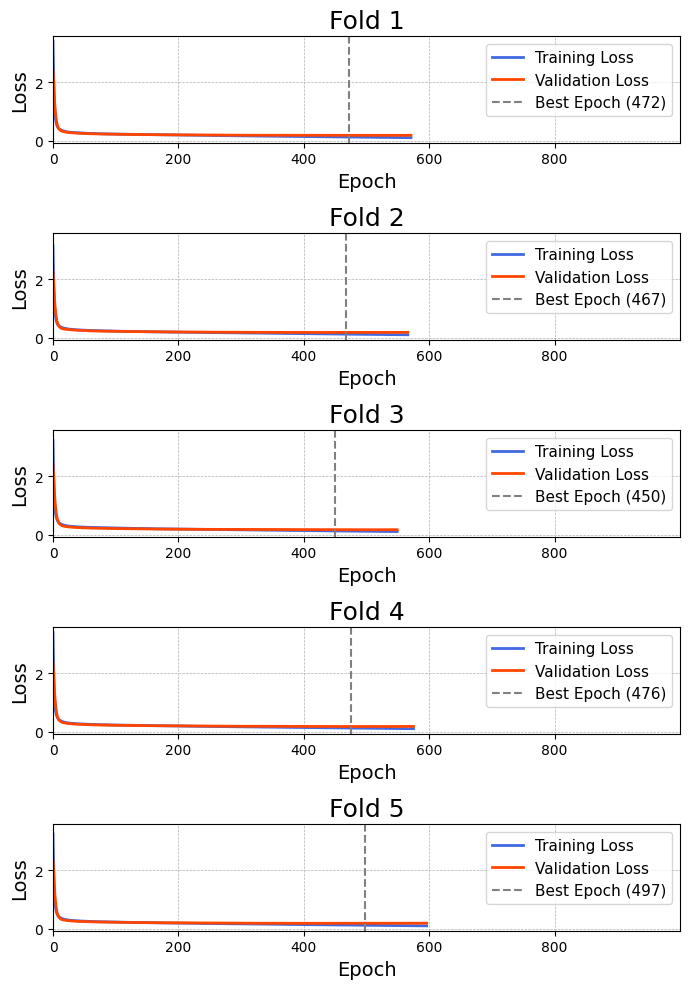

In [ ]:
# Creating a figure with 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(7, 10), sharey=True)

# Flattening
axes = axes.flatten()

# Iterating over the subplots
for i in range(5):

    # Plotting
    show_losses(
        training_losses=folds_training_losses[i],
        validation_losses=folds_validation_losses[i],
        best_epoch=folds_best_epochs[i],
        limit=1000,
        step=200,
        ax=axes[i]
    )

    # Setting title
    axes[i].set_title(f"Fold {i+1}", fontsize=18)

# Showing
plt.tight_layout()
plt.show()

Show the classification reports on the validation data for the 5 folds

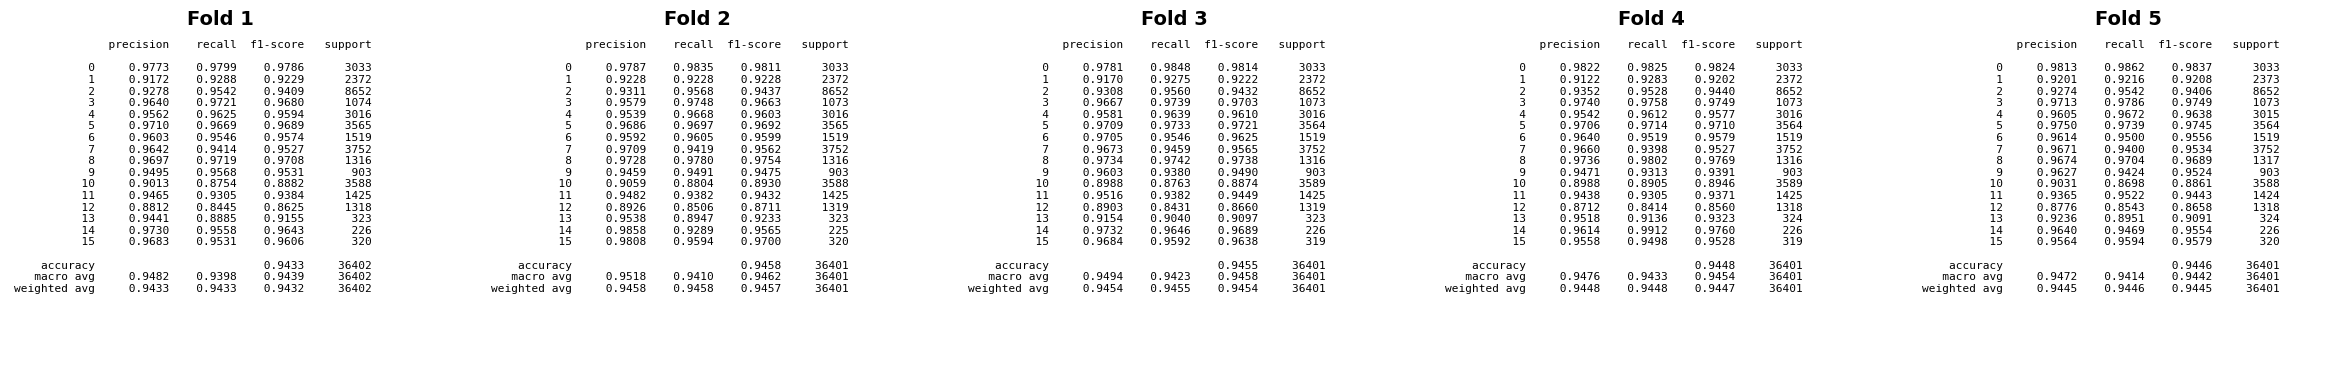

In [ ]:
# Creating a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(24, 4))

# Iterating over the subplots
for i in range(5):

    # Plotting the classification report
    axes[i].axis("off")
    axes[i].set_title(f"Fold {i+1}", fontsize=14, weight="bold")
    axes[i].text(
        0.01,
        0.98,
        folds_classification_reports[i],
        fontsize=8,
        ha="left",
        va="top",
        family="monospace",
    )

# Showing
plt.tight_layout()
plt.show()

Compute the average probabilities of the GraphSAGE models

In [ ]:
# Getting the class names and test products ids
class_columns = [f"class{i}" for i in range(16)]
product_ids = products[products["type"] == "test"]["product_id"].values

# Taking the average probabilities across all folds
average_sage_probs = np.mean(all_folds_probs, axis=0)
average_sage_submission = pd.DataFrame(average_sage_probs, columns=class_columns).round(
    4
)
average_sage_submission.insert(0, "product", product_ids)

# Saving
average_sage_submission.to_csv(
    drive_path + "submissions/submission_graphsage_5fold_avg.csv", index=False
)

### **GAT**

Define a class that represents the GAT neural network for product classification

In [ ]:
class GATClassifier(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads):
        """
        This is the constructor of the GAT classifier.

        :param in_channels: Number of input channels
        :param hidden_channels: Number of hidden channels
        :param out_channels: Number of output channels
        :param num_layers: Number of layers
        :param dropout: Dropout rate
        :param heads: Number of heads
        """

        # Calling the constructor of the superclass
        super().__init__()

        # Setting the layers and the dropout
        self.num_layers = num_layers
        self.dropout = dropout

        # Setting lists for the GAT layers and batch normalization
        self.gats = nn.ModuleList()
        self.bns = nn.ModuleList()

        # Appending the first GAT layer
        self.gats.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))

        # Adding batch normalization
        self.bns.append(nn.BatchNorm1d(hidden_channels * heads))

        # Iterating over the hidden layers
        for i in range(num_layers - 2):

            # Appending GAT layer
            self.gats.append(GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout))

            # Adding batch normalization
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Appending the output GAT layer (16 logits)
        self.gats.append(GATConv(hidden_channels, out_channels, heads=1, dropout=dropout))

        # Adding the input skip projection
        self.input_skip_proj = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        """
        The forward function of the GAT classifier.

        :param x: Input features
        :param edge_index: Graph edges
        :return: Output logits
        """

        # Getting the input skip projection
        input_skip = self.input_skip_proj(x)

        # Setting the residual
        residual = x

        # Iterating over the layers
        for i in range(self.num_layers - 1):

            # Passing from the GAT layer
            x = self.gats[i](x, edge_index)

            # Appling batch normalization
            x = self.bns[i](x)

            # Appling the ELU activation function
            x = F.elu(x)

            # Appling dropout
            x = F.dropout(x, p=self.dropout, training=self.training)

            # Checking the shapes
            if residual.shape == x.shape:

                # Adding the residual
                x = x + residual

            # Updating
            residual = x

        # Passing from the output layer (16 logits)
        x = self.gats[-1](x, edge_index)

        # Adding the input skip connection
        x = x + input_skip

        return x

Train the GAT classifier/model

In [ ]:
# Getting a stratified split
training_split, valiation_split = train_test_split(
    global_training_indices, test_size=0.1, stratify=training_labels, random_state=42
)

# Building the masks
final_training_mask = torch.zeros_like(training_mask_tensor)
final_validation_mask = torch.zeros_like(training_mask_tensor)
final_training_mask[training_split] = True
final_validation_mask[valiation_split] = True
final_training_mask = final_training_mask.to(device)
final_validation_mask = final_validation_mask.to(device)

# Building the data object
data_gat = Data(
    x=product_features,
    edge_index=edge_tensor,
    labels=labels,
    training_mask=final_training_mask,
    validation_mask=final_validation_mask,
    test_mask=test_mask,
).to(device)

# Initializing the model
gat_model = GATClassifier(
    in_channels=product_features.shape[1],
    hidden_channels=128,
    out_channels=16,
    num_layers=3,
    dropout=0.4,
    heads=2,
).to(device)

# Training the model
gat_model, gat_training_losses, gat_validation_losses, gat_best_epoch = (
    train_graph_neural_network(
        model=gat_model,
        data=data_gat,
        epochs=6000,
        patience=200,
        learning_rate=0.0005,
        weight_decay=0,
    )
)

Epoch 001 | Train Loss: 3.5817 | Validation Loss: 2.3685
Epoch 002 | Train Loss: 2.6604 | Validation Loss: 1.8234
Epoch 003 | Train Loss: 1.9767 | Validation Loss: 1.3931
Epoch 004 | Train Loss: 1.5107 | Validation Loss: 1.0871
Epoch 005 | Train Loss: 1.2191 | Validation Loss: 0.8805
Epoch 006 | Train Loss: 1.0342 | Validation Loss: 0.7409
Epoch 007 | Train Loss: 0.9016 | Validation Loss: 0.6446
Epoch 008 | Train Loss: 0.8143 | Validation Loss: 0.5764
Epoch 009 | Train Loss: 0.7477 | Validation Loss: 0.5274
Epoch 010 | Train Loss: 0.6921 | Validation Loss: 0.4914
Epoch 011 | Train Loss: 0.6509 | Validation Loss: 0.4641
Epoch 012 | Train Loss: 0.6150 | Validation Loss: 0.4430
Epoch 013 | Train Loss: 0.5884 | Validation Loss: 0.4263
Epoch 014 | Train Loss: 0.5643 | Validation Loss: 0.4128
Epoch 015 | Train Loss: 0.5454 | Validation Loss: 0.4017
Epoch 016 | Train Loss: 0.5237 | Validation Loss: 0.3926
Epoch 017 | Train Loss: 0.5118 | Validation Loss: 0.3849
Epoch 018 | Train Loss: 0.4945 

Show loss in training and validation data at all epochs of the folds

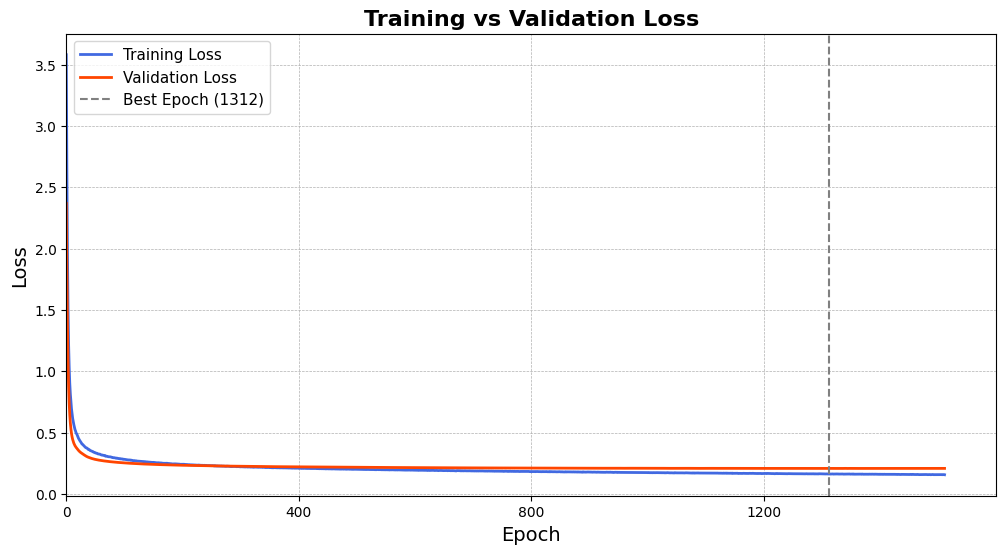

In [ ]:
# Showing
show_losses(
    gat_training_losses,
    gat_validation_losses,
    gat_best_epoch,
    limit=1600,
    step=400,
)

Get predictions on the test and validation datasets

In [ ]:
# Setting the model in evaludation mode
gat_model.eval()

# Without computing the gradients
with torch.no_grad():

    # Predicting
    logits = gat_model(data_gat.x, data_gat.edge_index)

    # Getting the predicted and true labels on the validation dataset
    validation_logits = logits[data_gat.validation_mask]
    validation_predictions = validation_logits.argmax(dim=1).cpu().numpy()
    true_validation_labels = data_gat.labels[data_gat.validation_mask].cpu().numpy()

    # Computing the classification report
    gat_classification_report = classification_report(true_validation_labels, validation_predictions, digits=4)

    # Getting the probabilities in test data
    gat_test_probs = F.softmax(logits[data_gat.test_mask], dim=1).cpu().numpy()

# Converting to a dataframe
gat_submission = pd.DataFrame(gat_test_probs, columns=class_columns).round(4)
gat_submission.insert(0, "product", product_ids)

# Saving
gat_submission.to_csv(drive_path + "submissions/submission_gat.csv", index=False)

Show the classification report on the validation data

In [ ]:
print("GAT Classification Report on Validation Data\n")
print(gat_classification_report)

GAT Classification Report on Validation Data

              precision    recall  f1-score   support

           0     0.9770    0.9796    0.9783      1517
           1     0.9067    0.9182    0.9124      1186
           2     0.9272    0.9505    0.9387      4326
           3     0.9560    0.9721    0.9640       537
           4     0.9516    0.9655    0.9585      1508
           5     0.9723    0.9658    0.9690      1782
           6     0.9635    0.9368    0.9500       760
           7     0.9531    0.9424    0.9477      1876
           8     0.9697    0.9726    0.9712       658
           9     0.9529    0.9424    0.9476       451
          10     0.8792    0.8724    0.8758      1794
          11     0.9408    0.9157    0.9281       712
          12     0.8854    0.8209    0.8520       659
          13     0.9338    0.8704    0.9010       162
          14     1.0000    0.9558    0.9774       113
          15     0.9742    0.9437    0.9587       160

    accuracy                      

### **GraphSAGE & GAT**

Combine both models and get the average probabilities

In [ ]:
# Taking the average of the probabilities
averaged_probabilities = (
    average_sage_submission[class_columns] + gat_submission[class_columns]
) / 2

# Getting the final dataframe
ensemble_submission = average_sage_submission[['product']].copy()
ensemble_submission[class_columns] = averaged_probabilities

# Saving
ensemble_submission.to_csv(drive_path + "submissions/submission_graphsage_gat.csv", index=False)